<a href="https://colab.research.google.com/github/w4bo/AA2425-unibo-mldm/blob/master/slides/lab-04-housing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The [`California Housing`](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/) case study

Our task is to use California census data to forecast housing prices given the population, median income, and median housing price for each block group in California.
Block groups are the smallest geographical unit for which the US Census Bureau publishes sample data (a block group typically has a population of 600 to 3,000 people).
We will just call them "districts" for short.

## Setup

In [10]:
import pandas as pd

df = pd.read_csv("https://raw.githubusercontent.com/w4bo/handsOnDataPipelines/main/materials/datasets/housing.csv", delimiter=",")
df

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND


## Profiling

In [11]:
# show some statistics on the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


## Profiling

In [12]:
df.describe(include='all')

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<1H OCEAN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9136
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909,NaN
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874,NaN
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000,NaN
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000,NaN
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000,NaN
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000,NaN


## Missing values

There are some missing values for `total_bedrooms`. What should we do?

Most Machine Learning algorithms cannot work with missing features. We have three options:

- Get rid of the corresponding districts (i.e., drop the rows)
    - `df.dropna(subset=["total_bedrooms"])`
- Get rid of the whole attribute (i.e., drop the columns)
    - `df.drop("total_bedrooms", axis=1)`
- Set the values to some value (zero, the mean, the median, etc.)
    - `df["total_bedrooms"].fillna(df["total_bedrooms"].mean())`

## Non-numeric attributes

`ocean_proximity` is a text attribute so we cannot compute its median. Some options:
- Get rid of the whole attribute. (`df.drop("ocean_proximity", axis=1`)
- Change from categorical to ordinal (e.g., `NEAR BAY` = 0, `INLAND` = 1)
    - Can foresee any problem in this?
    - ML algorithms will assume that two nearby values are more similar than two distant values. This may be fine in some cases (e.g., for ordered categories such as 'bad', 'average', 'good', 'excellent'), but it is obviously not the case for the ocean_proximity column (for example, categories 0 and 4 are clearly more similar than categories 0 and 1).
- Change from categorical to one hot encoding
    - To fix this issue, a common solution is to create one binary attribute per category: one attribute equal to 1 when the category is '<1H OCEAN' (and 0 otherwise), another attribute equal to 1 when the category is 'INLAND' (and 0 otherwise), and so on. This is called one-hot encoding, because only one attribute will be equal to 1 (hot), while the others will be 0 (cold). The new attributes are sometimes called dummy attributes

In [13]:
df["ocean_proximity"].value_counts()

,count
ocean_proximity,
<1H OCEAN,9136
INLAND,6551
NEAR OCEAN,2658
NEAR BAY,2290
ISLAND,5


<Axes: >

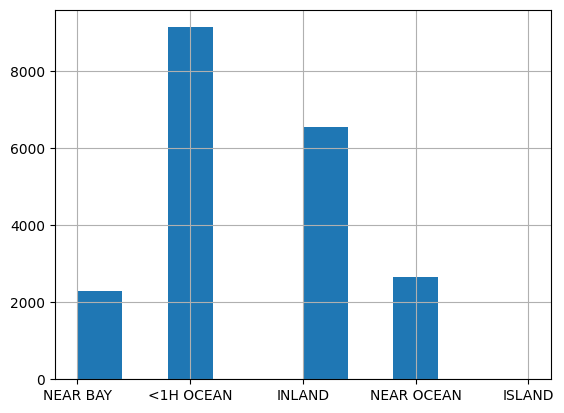

In [14]:
df["ocean_proximity"].hist()

## Encoding: ordinal


In [15]:
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()
y = ordinal_encoder.fit_transform(df[["ocean_proximity"]])
y

array([[3.],
       [3.],
       [3.],
       ...,
       [1.],
       [1.],
       [1.]])

## Encoding: one-hot encoding

In [16]:
y = pd.get_dummies(df["ocean_proximity"], prefix='ocean_proximity')
y

,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,False,False,False,True,False
1,False,False,False,True,False
2,False,False,False,True,False
3,False,False,False,True,False
4,False,False,False,True,False
...,...,...,...,...,...
20635,False,True,False,False,False
20636,False,True,False,False,False
20637,False,True,False,False,False
20638,False,True,False,False,False


## Correlation

Are there relationships between variables?


<Axes: >

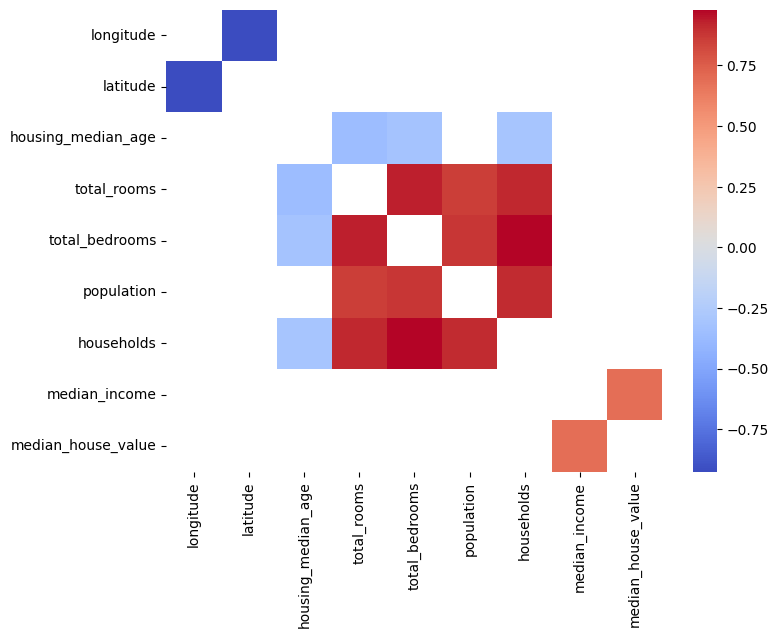

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

rho = df.corr(method='pearson', numeric_only=True)
min_corr = 0.3
kot = rho[(abs(rho) >= min_corr) & (rho < 1)]
plt.figure(figsize=(8, 6))
sns.heatmap(kot, cmap=sns.color_palette("coolwarm", as_cmap=True))

## Scaling attributes

Attributes have very different scales. Should we scale them?


- Normalization is good to use when you know that the distribution of your data does not follow a Gaussian distribution. This can be useful in algorithms that do not assume any distribution of the data like K-Nearest Neighbors and Neural Networks.
- Standardization, on the other hand, can be helpful in cases where the data follows a Gaussian distribution. However, this does not have to be necessarily true. Unlike normalization, standardization does not have a bounding range. So, even if you have outliers in your data, they will not be affected by standardization.


## Min-max normalization

In [18]:
num_df = df.drop(columns=['ocean_proximity', 'median_house_value'])
normalized_df = (num_df - num_df.min()) / (num_df.max() - num_df.min())
normalized_df

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
0,0.211155,0.567481,0.784314,0.022331,0.019863,0.008941,0.020556,0.539668
1,0.212151,0.565356,0.392157,0.180503,0.171477,0.067210,0.186976,0.538027
2,0.210159,0.564293,1.000000,0.037260,0.029330,0.013818,0.028943,0.466028
3,0.209163,0.564293,1.000000,0.032352,0.036313,0.015555,0.035849,0.354699
4,0.209163,0.564293,1.000000,0.041330,0.043296,0.015752,0.042427,0.230776
...,...,...,...,...,...,...,...,...
20635,0.324701,0.737513,0.470588,0.042296,0.057883,0.023599,0.054103,0.073130
20636,0.312749,0.738576,0.333333,0.017676,0.023122,0.009894,0.018582,0.141853
20637,0.311753,0.732200,0.313725,0.057277,0.075109,0.028140,0.071041,0.082764
20638,0.301793,0.732200,0.333333,0.047256,0.063315,0.020684,0.057227,0.094295


## Standardization

In [19]:
num_df = df.drop(columns=['ocean_proximity', 'median_house_value'])
normalized_df = (num_df - num_df.mean()) / num_df.std()
normalized_df

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
0,-1.327803,1.052523,0.982119,-0.804800,-0.970301,-0.974405,-0.977009,2.344709
1,-1.322812,1.043159,-0.607004,2.045841,1.348243,0.861418,1.669921,2.332181
2,-1.332794,1.038478,1.856137,-0.535733,-0.825541,-0.820757,-0.843616,1.782656
3,-1.337785,1.038478,1.856137,-0.624199,-0.718750,-0.766010,-0.733764,0.932945
4,-1.337785,1.038478,1.856137,-0.462393,-0.611959,-0.759828,-0.629142,-0.012881
...,...,...,...,...,...,...,...,...
20635,-0.758808,1.801603,-0.289180,-0.444974,-0.388886,-0.512579,-0.443438,-1.216099
20636,-0.818702,1.806285,-0.845373,-0.888682,-0.920466,-0.944382,-1.008396,-0.691576
20637,-0.823693,1.778194,-0.924829,-0.174991,-0.125468,-0.369528,-0.174037,-1.142566
20638,-0.873605,1.778194,-0.845373,-0.355591,-0.305826,-0.604415,-0.393743,-1.054557


# Exercise

1. Add a new column: `population_per_household = population / households`
1. Add a new column: `rooms_per_household = total_rooms / households`
1. Add a new column: `bedrooms_per_room = total_bedrooms / total_rooms`
1. Filling in (i.e., impute) missing values with the median value
1. Apply standardization to all the numeric columns
1. One hot encode `ocean_proximity` since it is a categorical attribute

In [20]:
# Write your code here